# Import Libraries <a id='import'></a>

In [1]:
import os
home = os.path.expanduser("~")
from glob import glob
import numpy as np
from astropy.io import fits

In [2]:
# Define CRDS paths *before* importing jwst pipeline
# otherwise you'll get FileNotFoundError: [Errno 2] : No such file or directory: '$HOME/crds_cache/config/jwst/server_config'

#os.environ["CRDS_PATH"] = "$HOME/crds_cache"
#os.environ["CRDS_PATH"] = '/grp/crds/cache/' at STScI
os.environ["CRDS_PATH"] = os.path.join(home, "crds_cache")
os.makedirs(os.environ['CRDS_PATH'], exist_ok=True)
print(os.environ['CRDS_PATH'])

os.environ["CRDS_SERVER_URL"] = "https://jwst-crds.stsci.edu"

import crds

/Users/dcoe/crds_cache


In [3]:
# Import JWST pipeline 

import jwst
from jwst import datamodels
from jwst.pipeline import Detector1Pipeline   # calwebb_detector1
from jwst.pipeline import Spec2Pipeline       # calwebb_spec2
from jwst.pipeline import Spec3Pipeline       # calwebb_spec3
from jwst.extract_1d import Extract1dStep     # Extract1D Individual Step
from jwst.associations import asn_from_list   # create association file
import json

print("JWST Calibration Pipeline Version = {}".format(jwst.__version__)) 
# Note if you're using a development version, it might not report the correct version number here

JWST Calibration Pipeline Version = 1.13.4


In [4]:
try:
    print("Current Operational CRDS Context = {}".format(crds.get_default_context()))
except:
    print('CRDS server not found (are you offline?)')

Current Operational CRDS Context = jwst_1225.pmap


In [5]:
# To run faster on multiple cores in parallel
import multiprocessing as mp 
print("Number of processors: ", mp.cpu_count())

Number of processors:  10


In [6]:
# To retrieve data from MAST
import astroquery
print('astroquery version', astroquery.__version__)
from astroquery.mast import Observations, Mast

from astropy.table import Table, vstack, unique

astroquery version 0.4.6


In [7]:
# To plot and view results

import matplotlib # as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})  # 18

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.patheffects as pe # https://stackoverflow.com/questions/25426599/matplotlib-how-to-buffer-label-text

from astropy.visualization import simple_norm, ImageNormalize, AsinhStretch, ManualInterval, LogStretch, LinearStretch
from astropy.stats import sigma_clip, sigma_clipped_stats  # , SigmaClip

# Helper Functions <a id='helper'></a>

In [8]:
from IPython.display import JSON  # nicer interactive output of JSON dictionaries

def print_dict(d, indent=0): # another way to view dictionary contents
    for key in d.keys():
        val = d[key]
        try:
            keys = val.keys()
            print(' ' * indent, key)
            print_dict(val, indent+4)
        except:
            if type(val) == type([]):
                for i, item in enumerate(val):
                    print(' ' * indent, '[%d]' % i)
                    print_dict(item, indent+4)
            else:
                print(' ' * indent, key, ':', d[key])

In [9]:
def between(lo, x, hi):
    return (lo <= x) * (x <= hi)

In [10]:
# Helper functions to select subset of files from list
def allin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element not in list_or_string:
            return False
    return True

def anyin(elements, list_or_string):
    if type(elements) == str:
        elements = elements.split()
    for element in elements:
        if element in list_or_string:
            return True
    return False

# Select subset of files containing all search strings
def select_files(all_files, search_strings=[]):
    chosen_files = [file for file in all_files if allin(search_strings, file)]
    if len(chosen_files) == 1:
        chosen_files = chosen_files[0]
    return chosen_files    

# Wavelength grid

### S2D model WCS transform –> RA, Dec, wavelength

https://jwst-pipeline.readthedocs.io/en/latest/_modules/jwst/assign_wcs/nirspec.html

In [11]:
spec3_output_dir = 'spec3'
source_id = 6355

s2d_files = glob(os.path.join(spec3_output_dir, '*_s2d.fits'))
s2d_file  = select_files(s2d_files, ['s%05d' % source_id])
s2d_file

'spec3/jw02736-o007_s06355_nirspec_f290lp-g395m_s2d.fits'

In [12]:
s2d_model = datamodels.open(s2d_file)
#s2d_model.info(max_rows=99999)  # show all contents
#s2d_data = s2d_model.data + 0

In [13]:
if 'slits' in list(s2d_model):  # s2d has all the objects; extract the one with source_id
    source_ids = [slit.source_id for slit in s2d_model.slits]
    i_slit = source_ids.index(source_id)
    slit_model = s2d_model.slits[i_slit]
else:  # s2d only has one object
    slit_model = s2d_model
    i_slit = 0

s2d_data = slit_model.data + 0  # load and make copy
s2d_data = np.where(slit_model.err, s2d_data, np.nan)  # Replace zeros with nan where there is no data

In [14]:
slit_wcs = s2d_model.meta.wcs
y, x = np.mgrid[:s2d_data.shape[0], :s2d_data.shape[1]] # grid of pixel x,y indices 
det2sky = slit_wcs.get_transform('detector', 'world') # coordinate transform from detector pixels to sky 
ra, dec, s2d_waves = det2sky(x, y) # RA, Dec, wavelength (microns) for each pixel 
s2d_wave = s2d_waves[0, :] # only need a single row of values since this is the rectified spectrum 

In [15]:
s2d_wave

array([2.84863722, 2.85043148, 2.85222575, ..., 5.28289045, 5.28467829,
       5.28646621])

### can also read wavelength grid from x1d file

In [16]:
# Load 1D extraction
x1d_file = s2d_file.replace('s2d', 'x1d')
print(x1d_file)
x1d_model = datamodels.open(x1d_file)
#x1d_model.info(max_rows=99999)  # show all contents

spec3/jw02736-o007_s06355_nirspec_f290lp-g395m_x1d.fits


In [17]:
x1d_wave = x1d_model.spec[i_slit].spec_table.WAVELENGTH

In [18]:
x1d_wave

array([2.84863722, 2.85043148, 2.85222575, ..., 5.28289045, 5.28467829,
       5.28646621])

### They're identical

In [19]:
s2d_wave - x1d_wave

array([-4.4408921e-16, -4.4408921e-16,  4.4408921e-16, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00])

In [20]:
np.max(np.abs(s2d_wave - x1d_wave))

8.881784197001252e-16

## Slit Frame

In [21]:
slit2sky = slit_wcs.get_transform('slit_frame', 'world')

In [22]:
slit2sky(1, 1, 1)

(110.8449167959692, -73.43509123541304, 1000000.0)

slit size:  
0.20" dispersion  
0.46" cross-dispersion

5 slitlets long... Might have expected 5 * 0.46" = 2.3" = 23 pixels (0.1" / pix)

In [23]:
slit_model.ysize

38

In [24]:
s2d_data.shape[0]

41

Cross-dispersion...

In [25]:
single_slit_ysize = slit_model.ysize / 5.
slit_xsize = single_slit_ysize * 0.20 / 0.46
slit_xsize, single_slit_ysize

(3.3043478260869565, 7.6)

In [26]:
slit_xsize = 3

Create grid

In [27]:
slit_y, slit_x = np.mgrid[:slit_model.ysize, :slit_xsize] # grid of pixel x,y indices 

In [28]:
ra, dec, zero = slit2sky(slit_x, slit_y, 0) # RA, Dec for each pixel 

(110.858334775699, 110.84378194167009)

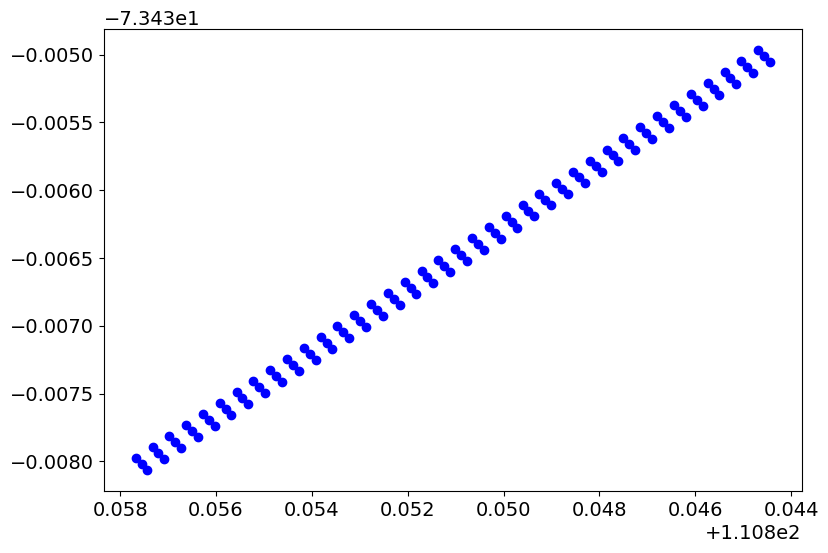

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(9,6))
plt.plot(ra, dec, 'bo')
plt.xlim(plt.xlim()[::-1])